In [3]:
import torch
from torchvision import datasets, transforms

from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
import os
import math

In [4]:

# Hyper-parameters
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 20000
set_size = 60000
batch_size = 2
sample_dir = 'samples'
save_dir = 'save'

# Create a directory if not exists
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Image processing
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5, 0.5, 0.5),   # 3 for RGB channels
                                     std=(0.5, 0.5, 0.5))])


# Data loader
# data_loader = torch.utils.data.DataLoader(dataset=mnist,
#                                          batch_size=batch_size, 
#                                          shuffle=True)
# Download MNIST dataset
mnist_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transform, 
                               download=True)
# Split original training set into 70% train and 30% validation
train_size = int(0.7 * len(mnist_dataset))
val_size = len(mnist_dataset) - train_size
train_dataset, val_dataset = random_split(mnist_dataset, [train_size, val_size])

# Select a random image from the new training set
random_index = np.random.randint(len(train_dataset))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

mnist_images = train_dataloader.dataset.dataset.data
mnist_labels = train_dataset.dataset.targets


In [5]:

# Hyper-parameters
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 20000
set_size = 60000
batch_size = 2
sample_dir = 'samples'
save_dir = 'save'

# Create a directory if not exists
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Image processing
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5, 0.5, 0.5),   # 3 for RGB channels
                                     std=(0.5, 0.5, 0.5))])


# Data loader
# data_loader = torch.utils.data.DataLoader(dataset=mnist,
#                                          batch_size=batch_size, 
#                                          shuffle=True)
# Download MNIST dataset
fashion_mnist_dataset = datasets.FashionMNIST(root='data', 
                               train=True, 
                               transform=transform, 
                               download=True)
# Split original training set into 70% train and 30% validation
train_size = int(0.7 * len(fashion_mnist_dataset))
val_size = len(fashion_mnist_dataset) - train_size
train_dataset, val_dataset = random_split(fashion_mnist_dataset, [train_size, val_size])

# Select a random image from the new training set
random_index = np.random.randint(len(train_dataset))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

fashion_mnist_images = train_dataloader.dataset.dataset.data
fashion_mnist_labels = train_dataset.dataset.targets

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),                # Convert to tensor
    transforms.Grayscale(num_output_channels=1),  # Convert RGB to Grayscale
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

train_dataset = datasets.CIFAR10(root='data', 
                               train=True, 
                               transform=transform, 
                               download=True)

# # Split original training set into 70% train and 30% validation
train_size = int(0.7 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# # Select a random image from the new training set
# random_index = np.random.randint(len(train_dataset))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
cifar_images = torch.tensor(train_dataloader.dataset.dataset.data).permute(0, 3, 1, 2)  # Convert to Tensor & Normalize

# cifar_images = train_dataloader.dataset.dataset.data
cifar_labels = train_dataset.dataset.targets

to_grayscale = transforms.Grayscale(num_output_channels=1)
cifar_gray = torch.stack([to_grayscale(img) for img in cifar_images])

In [7]:
def compute_cdf_mapping(images):
    """
    Compute the CDF mapping for each pixel across all images.
    """
    
    vector_size = images.shape[1]
    images = images.view(-1, vector_size)  # Flatten images
    sorted_pixels, _ = torch.sort(images, dim=0)
    cdf = torch.linspace(0, 1, images.shape[0])
    pixel_cdf_map = {}
    
    for i in range(vector_size):
        pixel_cdf_map[i] = (sorted_pixels[:, i], cdf)
    
    return pixel_cdf_map

def transform_original_to_uniform(image, pixel_cdf_map, reverse=False):
    """
    Transform an image using the pixel CDF mapping.
    """
    image = image.view(-1)  # Flatten image
    transformed_image = torch.zeros_like(image, dtype=torch.float32)
    
    pixel_size = int(image.shape[0] ** 0.5)
    for i in range(pixel_size * pixel_size):
        pixel_values, cdf_values = pixel_cdf_map[i]
        
        if not reverse:
            # Forward transformation (find CDF value for each pixel)
            indices = torch.searchsorted(pixel_values, image[i])
            transformed_image[i] = cdf_values[min(indices, len(cdf_values) - 1)]
        else:
            # Reverse transformation (find original pixel from CDF value)
            indices = torch.searchsorted(cdf_values, image[i])
            transformed_image[i] = pixel_values[min(indices, len(pixel_values) - 1)]
    
    transformed_image = transformed_image.view(pixel_size, pixel_size)  # Reshape back to image size
    return transformed_image

def compute_mean_and_covariance_in_data_space(images, epsilon=1e-6):
    """
    Compute the covariance matrix of the dataset, ensuring it is positive definite.
    """
    images = images.float()  # Ensure floating-point type
    images = images.view(images.shape[0], -1)  # Flatten images
    mean_vector = torch.mean(images, dim=0, keepdim=True)
    centered_images = images - mean_vector
    covariance_matrix = torch.matmul(centered_images.T, centered_images) / (images.shape[0] - 1)
    
    # Regularization: Add a small identity matrix to ensure positive definiteness
    covariance_matrix += epsilon * torch.eye(covariance_matrix.shape[0])
    
    return covariance_matrix, mean_vector

def compute_covariance_in_uniform_sapce(training_data, epsilon = 1e-5):
    """
    Compute the covariance matrix Σ_u of uniforms obtained by applying marginal CDFs to a dataset of shape (n, d, d).
    
    Args:
        training_data (torch.Tensor): Input tensor of shape (n, d, d), where:
            - n: Number of samples
            - d: Number of pixels per dimension
    
    Returns:
        torch.Tensor: Covariance matrix Σ_u of shape (d*d, d*d) for the uniforms.
    """
    n, d, _ = training_data.shape
    
    # Flatten the images into vectors: shape (n, d*d)
    flattened = training_data.view(n, -1)  # (n, d^2)
    
    # Compute ranks for each pixel across samples
    ranks = torch.argsort(torch.argsort(flattened, dim=0), dim=0)  # (n, d^2)
    
    # Convert ranks to uniforms using (rank + 1)/(n + 1)
    uniforms = (ranks.float() + 1.0) / (n + 1.0)  # (n, d^2)
    
    # Center the uniforms (mean of U(0,1) is 0.5)
    centered = uniforms - 0.5  # (n, d^2)
    
    # Compute covariance matrix (unbiased estimator)
    covariance_matrix_unifrom = torch.matmul(centered.T, centered) / (n - 1)  # (d^2, d^2)
    
    return covariance_matrix_unifrom + epsilon*torch.eye(covariance_matrix_unifrom.shape[0])

def generate_random_uniform_images_from_gaussian(covariance_matrix_gaussian, num_samples = 1):
    vector_size = covariance_matrix_gaussian.size(0)
    num_pixels = int(vector_size**0.5)
    mean = torch.zeros(vector_size, device=covariance_matrix_gaussian.device)
    
    # Create the multivariate normal distribution
    mvn = torch.distributions.MultivariateNormal(
        loc=mean,
        covariance_matrix=covariance_matrix_gaussian
    )
    
    # Generate samples
    gaussian_samples = mvn.rsample((num_samples,))
    uniform_samples = 0.5 * (1 + torch.erf(gaussian_samples / np.sqrt(2)))  # Convert Gaussian to Uniform [0,1]
    return uniform_samples.reshape(num_samples, num_pixels, num_pixels)


def generate_random_uniform_images(covariance_matrix, num_samples = 1):
    """
    Generate samples from a multivariate normal distribution with mean 0 and given covariance matrix.
    
    Args:
        num_samples (int): Number of samples to generate.
        covariance_matrix (torch.Tensor): Covariance matrix of shape (num_pixels, num_pixels).
        
    Returns:
        torch.Tensor: Tensor of shape (num_samples, num_pixels) containing the samples.
    """
    vector_size = covariance_matrix.size(0)
    num_pixels = int(vector_size**0.5)
    mean = torch.zeros(vector_size, device=covariance_matrix.device)
    
    # Create the multivariate normal distribution
    mvn = torch.distributions.MultivariateNormal(
        loc=mean,
        covariance_matrix=covariance_matrix
    )
    
    # Generate samples
    gaussian_samples = mvn.rsample((num_samples,))
    uniform_samples = 0.5 * (1 + torch.erf(gaussian_samples / np.sqrt(2)))  # Convert Gaussian to Uniform [0,1]
    return uniform_samples.reshape(num_samples, num_pixels, num_pixels)

def transform_dataset_to_uniform_and_gaussian_vectorized(dataset):
    """
    Transform an entire dataset of images (tensor of shape (n, p, p)) so that for each pixel location,
    the empirical distribution of pixel values becomes uniform in [0,1]. Then, using the relation
    z = sqrt(2) * erfinv(2u - 1), convert the uniform dataset into a Gaussian distributed dataset.
    
    Args:
        dataset (torch.Tensor): Tensor of shape (n, p, p)
        
    Returns:
        uniform_dataset (torch.Tensor): Transformed dataset with shape (n, p, p) with values in [0,1].
        gaussian_dataset (torch.Tensor): Dataset transformed to be Gaussian distributed.
    """
    n, p, _ = dataset.shape
    # Flatten images: shape (n, p*p)
    flat_data = dataset.view(n, -1)
    
    # Compute the rank for each pixel across the dataset via double argsort.
    # First argsort sorts the values; the second argsort recovers the rank.
    ranks = flat_data.argsort(dim=0).argsort(dim=0).float()
    
    # Normalize ranks to [0,1]
    uniform_flat = ranks / (n - 1)
    
    # Reshape back to (n, p, p)
    uniform_dataset = uniform_flat.view(n, p, p)
    
    # Convert the uniform dataset to Gaussian distributed data:
    # For each pixel, apply: z = sqrt(2) * erfinv(2u - 1)
    gaussian_dataset = torch.erfinv(2 * uniform_dataset - 1) * torch.sqrt(torch.tensor(2.0))
    
    return uniform_dataset, gaussian_dataset


# def generate_uniform_iman_conover(covariance_matrix, n_samples=10000):
#     """
#     Generate a sample from a d-dimensional distribution with Uniform(0,1) marginals 
#     whose covariance is approximately the given covariance_matrix.
    
#     The method uses the Iman–Conover procedure.
    
#     Args:
#         covariance_matrix (np.ndarray): A d x d target covariance matrix.
#             (For Uniform[0,1], the variance is 1/12, so the diagonal of covariance_matrix
#             should be about 1/12.)
#         n_samples (int): Number of samples to generate for the Iman–Conover adjustment.
        
#     Returns:
#         sample (np.ndarray): A d x 1 column vector drawn from the adjusted Uniform(0,1) distribution.
#     """
#     # Dimension (d) inferred from the covariance matrix
#     d = covariance_matrix.shape[0]
    
#     # For Uniform[0,1], variance = 1/12. So the target correlation matrix is:
#     R_target = covariance_matrix * 12.0
    
#     # Step 1: Generate independent Uniform(0,1) samples: shape (n_samples, d)
#     U = np.random.uniform(0, 1, size=(n_samples, d))
    
#     # Step 2: Standardize each column of U
#     U_std = (U - U.mean(axis=0)) / U.std(axis=0, ddof=1)
    
#     # Compute the empirical correlation matrix of U_std
#     R_empirical = np.corrcoef(U_std, rowvar=False)
    
#     # Step 3: Compute Cholesky factors for the empirical and target correlation matrices
#     L_empirical = np.linalg.cholesky(R_empirical)
#     L_target = np.linalg.cholesky(R_target)
    
#     # Step 4: Compute the adjustment matrix
#     A = L_target @ np.linalg.inv(L_empirical)
    
#     # Adjust the standardized samples
#     Z = U_std @ A.T
    
#     # Step 5: For each variable (column), reassign values based on the ranks of Z,
#     # so that the marginals remain Uniform(0,1) but the correlation structure is adjusted.
#     U_adjusted = np.empty_like(U)
#     for j in range(d):
#         order = np.argsort(Z[:, j])
#         sorted_vals = np.sort(U[:, j])
#         U_adjusted[order, j] = sorted_vals
    
#     # Step 6: Choose one sample (e.g., the first row) and return it as a column vector.
#     sample = U_adjusted[0, :].reshape(-1, 1)
#     uniform_random_image = torch.tensor(sample).view(-1)
#     return uniform_random_image

def generate_uniform_from_gaussian(covariance_matrix_uniform, epsilon=1e-4):
    """
    Generates a column vector of uniform samples with the specified covariance matrix,
    using a multivariate Gaussian transformation. Handles PyTorch tensors and allows
    diagonal entries close to (but not exactly) 1/12.
    """
    d = covariance_matrix_uniform.size(0)
    
    # Compute standard deviations for each uniform variable
    sigma = torch.sqrt(torch.diag(covariance_matrix_uniform))  # Shape: (d,)
    
    # Compute correlation matrix for the uniforms
    outer_sigma = torch.outer(sigma, sigma)
    R_uniform = covariance_matrix_uniform / outer_sigma  # Shape: (d, d)
    
    # Compute Gaussian correlation matrix using adjusted formula
    R_gaussian = 2 * torch.sin((math.pi / 6) * R_uniform)
    R_gaussian.fill_diagonal_(1.0)  # Ensure diagonal is exactly 1
    
    # Cholesky decomposition (requires positive definite matrix)
    try:
        L = torch.linalg.cholesky(R_gaussian + epsilon*torch.eye(d))
    except RuntimeError as e:
        raise ValueError("Invalid covariance: Resulting Gaussian correlation is not positive definite.") from e
    
    # Generate multivariate Gaussian sample
    z = torch.randn(d)  # Standard normal sample
    gaussian_sample = L @ z  # Shape: (d,)
    
    # Transform Gaussian to uniform using CDF
    uniform_sample = 0.5 * (1 + torch.erf(gaussian_sample / math.sqrt(2)))  # Shape: (d,)
    
    # Scale to match desired covariance (adjust variances and covariances)
    scale_factor = torch.sqrt(12 * torch.diag(covariance_matrix_uniform))
    scaled_uniform = uniform_sample * scale_factor + 0.5 * (1 - scale_factor)
    
    return scaled_uniform.reshape(-1, 1)  # Return as column vector
def compute_gaussian_covariance_from_uniform(covariance_matrix_unifrom, epsilon = 1e-4):
    """
    Compute the Gaussian covariance matrix from the uniform covariance matrix.
    
    Args:
        covariance_matrix_unifrom (torch.Tensor): Covariance matrix of the uniforms, shape (d, d).
    
    Returns:
        torch.Tensor: Gaussian covariance matrix, shape (d, d).
    """
    # Compute Pearson correlation matrix of the uniforms
    diag_var_u = torch.diag(covariance_matrix_unifrom)  # Variances of uniforms (should be ~1/12)
    std_u = torch.sqrt(diag_var_u)    # Standard deviations of uniforms
    outer_std = torch.outer(std_u, std_u)
    R_u = covariance_matrix_unifrom / outer_std         # Pearson correlation matrix of uniforms

    # Compute Gaussian correlation matrix
    R_n = 2 * torch.sin((math.pi / 6) * R_u)

    # Ensure diagonal is exactly 1 (due to numerical precision)
    R_n.fill_diagonal_(1.0)
    covariance_matrix_gaussian =  R_n + torch.eye(R_u.shape[0])
    return covariance_matrix_gaussian

def compute_pixel_cdf_map(images, max_pixel_value = 255):
    """
    Compute the empirical CDF for each pixel position across all images.
    
    Args:
        images (torch.Tensor): Tensor of shape (num_samples, pixel_size, pixel_size),
                               containing grayscale images with integer pixel values (0-255).
    
    Returns:
        torch.Tensor: A tensor of shape (pixel_size**2, 256), where each row contains
                      the empirical CDF for a given pixel position.
    """
    
    num_samples, pixel_size, _ = images.shape
    # max_pixel_value = images.max()
    
    # Flatten images along the pixel dimension
    images_flat = images.view(num_samples, -1)  # Shape: (num_samples, pixel_size**2)
    
    # Initialize the CDF map
    cdf_map = torch.zeros((images_flat.shape[1], max_pixel_value + 1), device=images.device)
    
    # Compute the empirical CDF for each pixel location
    for i in range(images_flat.shape[1]):
        pixel_values = images_flat[:, i]  # All values for a specific pixel position
        hist = torch.bincount(pixel_values, minlength=max_pixel_value + 1).float()  # Count occurrences
        cdf_map[i] = hist.cumsum(dim=0) / num_samples  # Normalize to get CDF
    
    return cdf_map
import torch

def transform_dataset_to_uniform_distribution(images, cdf_map, reverse=False):
    """
    Transform the dataset into a uniform [0,1] dataset using pixel-wise empirical CDF.
    If reverse=True, transform back to the original space.

    Args:
        images (torch.Tensor): Input dataset of shape (num_samples, pixel_size, pixel_size).
                               If reverse=False, dtype=torch.uint8; if reverse=True, dtype=torch.float32.
        cdf_map (torch.Tensor): Empirical CDF map of shape (pixel_size**2, 256).
        reverse (bool): If True, transform back to the original pixel space.

    Returns:
        torch.Tensor: Transformed dataset of the same shape as input.
    """
    num_samples, pixel_size, _ = images.shape
    images_flat = images.view(num_samples, -1)  # Flatten for batch processing
    cdf_map = cdf_map.to(images.device)  # Ensure cdf_map is on the same device

    if not reverse:
        # Forward transformation: Map pixel values to uniform [0,1]
        images_flat = images_flat.long()  # Convert to long for indexing
        transformed_images_flat = cdf_map[torch.arange(images_flat.shape[1], device=images.device).unsqueeze(0), images_flat]
        
        # Reshape and ensure float output
        transformed_images = transformed_images_flat.view(num_samples, pixel_size, pixel_size).to(torch.float32)
        # gaussian_images = torch.erfinv(2 * transformed_images - 1) * torch.sqrt(torch.tensor(2.0))
        return transformed_images#, gaussian_images

    else:
        # Reverse transformation: Map uniform values back to pixel space
        pixel_positions = torch.arange(cdf_map.shape[0], device=images.device)

        # Use `searchsorted` for **each** pixel position separately
        transformed_images_flat = torch.stack([
            torch.searchsorted(cdf_map[i], images_flat[:, i], right=True) for i in range(cdf_map.shape[0])
        ], dim=1).clip(0, 255)  # Shape (num_samples, pixel_size**2)

        # Reshape and ensure byte output
        transformed_images = transformed_images_flat.view(num_samples, pixel_size, pixel_size).to(torch.uint8)
        return transformed_images

def plot_histogram_of_data(data: torch.Tensor, bins: int = 50, color: str = 'blue',
                     title: str = 'Empirical PDF', xlabel: str = 'Value', 
                     ylabel: str = 'Density') -> tuple[plt.Figure, plt.Axes]:
    """
    Plot the histogram of a flattened tensor (assumed to represent CDF values).

    Args:
        data: Input tensor of shape (N,) or (batch_size, ...). Will be flattened.
        bins: Number of histogram bins.
        color: Histogram color.
        title: Plot title.
        xlabel: x-axis label.
        ylabel: y-axis label.

    Returns:
        Matplotlib figure and axes.
    """
    # Convert to numpy and flatten
    data_np = data.flatten().cpu().numpy()  # Handles GPU tensors
    
    # Create plot
    fig, ax = plt.subplots(1, 1, figsize=(6, 5), tight_layout=True)
    ax.hist(data_np, bins=bins, density=True, alpha=0.6, color=color, label='Empirical PDF')
    ax.axhline(1.0, color='black', linestyle='--', label='Uniform PDF')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    
    return fig, ax

def min_max_normalization(data):
    return (data - data.min()) / (data.max() - data.min())

def transform_data_to_have_the_true_covariance(input_images, covariance_matrix_true):
    """
    Transforms a batch of input images such that their covariance matches the given real data covariance.

    Args:
        input_images (torch.Tensor): Fake images sampled from a input distribution (num_samples, p, p).
        covariance_matrix_true (torch.Tensor): Target covariance matrix of real data (p*p, p*p).

    Returns:
        torch.Tensor: Transformed input images with the same covariance as real data (num_samples, p, p).
    """

    num_samples, pixel_size, _ = input_images.shape
    p2 = pixel_size ** 2  # Flattened pixel count

    # Flatten images
    input_images_flat = input_images.view(num_samples, p2)


    # Compute empirical covariance of input samples
    mean_input = input_images_flat.mean(dim=0, keepdim=True)
    centered_input = input_images_flat - mean_input
    covariance_input = (centered_input.T @ centered_input) / (num_samples - 1)

    # Compute Cholesky decomposition (or Eigen decomposition)
    L_real = torch.linalg.cholesky(covariance_matrix_true)  # L_real @ L_real.T = covariance_matrix_true
    L_input = torch.linalg.cholesky(covariance_input)  # L_input @ L_input.T = covariance_input

    # Compute correction matrix A
    correction_matrix = L_real @ torch.linalg.inv(L_input)

    # Apply correction matrix
    transformed_images_flat = (input_images_flat - mean_input) @ correction_matrix.T
    transformed_images = transformed_images_flat.view(num_samples, pixel_size, pixel_size)

    return transformed_images

In [20]:
from scipy.linalg import sqrtm

def generate_uniform_random_cifar_rgb_per_class(label_idx, num_samples = 5000, set_name = 'cifar-rgb', epsilon = 0):
    num_bands = 1
    if set_name == 'mnist':
        images = mnist_images
        train_images = mnist_images[mnist_labels == label_idx]
        pixel_size = images.shape[2]
        train_images = train_images.unsqueeze(1)
    elif set_name == 'fashion-mnist':
        images = fashion_mnist_images[fashion_mnist_labels == label_idx]
        pixel_size = images.shape[2]
        train_images = fashion_mnist_images[fashion_mnist_labels == label_idx]
        train_images = train_images.unsqueeze(1)
    elif set_name == 'cifar-gray':
        pixel_size = cifar_images.shape[2]
        train_images = cifar_gray[torch.tensor(cifar_labels) == label_idx,:,:].squeeze(dim=1)
        train_images = train_images.unsqueeze(1)
    elif set_name == 'cifar-rgb':
        num_bands = 3
        pixel_size = cifar_images.shape[2]
        train_images = cifar_images[torch.tensor(cifar_labels) == label_idx,:,:,:]
        # train_images = torch.zeros(5000, 3, pixel_size, pixel_size)
        # for band_idx in range(num_bands): 
            # train_images = cifar_images[torch.tensor(cifar_labels) == label_idx,band_idx,:,:].squeeze(dim=1)
    else: return [], []
    # print(train_images.shape)
    num_samples = min(num_samples, train_images.shape[0])
    uniform_real_images = torch.zeros(num_samples, num_bands, pixel_size, pixel_size)
    uniform_fake_images = torch.zeros(num_samples, num_bands, pixel_size, pixel_size)
    covariance_matrix_real_uniform = torch.zeros(num_bands, pixel_size**2, pixel_size**2)
    covariance_matrix_real_gaussian = torch.zeros(num_bands, pixel_size**2, pixel_size**2)
    covariance_matrix_real_images = torch.zeros(num_bands, pixel_size**2, pixel_size**2)
    correction_matrix = torch.zeros(num_bands, pixel_size**2, pixel_size**2)
    eigen_vector_data = torch.zeros(num_bands, pixel_size**2, pixel_size**2)
    mean_vecotr_data = torch.zeros(num_bands, pixel_size**2)
    covariance_matrix_uniform = torch.zeros(num_bands, pixel_size**2, pixel_size**2)
    synthetic_image = torch.zeros(num_bands, pixel_size, pixel_size)
    # pixel_cdf_map = [0]*num_bands
    pixel_cdf_map = torch.zeros(num_bands, pixel_size**2, 256)
    synthetic_images = torch.zeros(num_bands, num_samples, pixel_size, pixel_size)
    for band_idx in range(num_bands):

        uniform_real_images[:, band_idx, :, :]= transform_dataset_to_uniform_distribution(train_images[:, band_idx, :, :], pixel_cdf_map[band_idx, :], reverse=False)
        # uniform_real_images, _ = transform_dataset_to_uniform_and_gaussian_vectorized(train_images)
        covariance_matrix_real_images[band_idx, :, :], _ = compute_mean_and_covariance_in_data_space(train_images[:, band_idx, :, :], epsilon=epsilon)
        covariance_matrix_real_uniform[band_idx, :, :], _ = compute_mean_and_covariance_in_data_space(uniform_real_images[:, band_idx,: ,:], epsilon=epsilon)
        covariance_matrix_real_gaussian[band_idx, :, :] = compute_gaussian_covariance_from_uniform(covariance_matrix_real_uniform[band_idx, :, :], epsilon = epsilon)


        # uniform_fake_images = generate_random_uniform_images(covariance_matrix_real_uniform, num_samples = num_samples)
        uniform_fake_images[:, band_idx, :, :] = generate_random_uniform_images(covariance_matrix_real_uniform[band_idx, :, :], num_samples = num_samples)
        uniform_fake_images[:, band_idx, :, :] = generate_random_uniform_images_from_gaussian(covariance_matrix_real_gaussian[band_idx, :, :], num_samples= num_samples)
        # uniform_fake_images[:, band_idx, :, :] = transform_data_to_have_the_true_covariance(uniform_fake_images[:, band_idx, :, :], covariance_matrix_real_uniform[band_idx, :, :])
        # uniform_fake_images = (uniform_fake_images - uniform_fake_images.min()) / (uniform_fake_images.max() - uniform_fake_images.min())

        # uniform_fake_images = generate_random_uniform_images(torch.eye(pixel_size**2), num_samples = num_samples)
        # uniform_fake_images = torch.rand(num_samples,pixel_size,pixel_size)

        synthetic_images[band_idx, :, :, :] = transform_dataset_to_uniform_distribution(uniform_fake_images[:, band_idx, :, :], pixel_cdf_map[band_idx, :], reverse=True)
        # print(synthetic_images)
        # synthetic_images[band_idx, :, :, :] = transform_data_to_have_the_true_covariance(synthetic_images[band_idx, :, :].float(), covariance_matrix_real_images[band_idx, :, :].float())

    return uniform_real_images, uniform_fake_images, synthetic_images
 
def plot_synthetic_images(synthetic_images, label_idx, set_name = 'cifar-rgb', number_of_rows_and_columns = 10):
    num_bands = synthetic_images.shape[0]
    pixel_size = synthetic_images.shape[-1]
    fig, axs = plt.subplots(number_of_rows_and_columns, number_of_rows_and_columns, figsize=(number_of_rows_and_columns, number_of_rows_and_columns))
    idx = -1
    synthetic_image = synthetic_images[:,0,:,:]
    correction_matrix = torch.zeros(num_bands, pixel_size**2, pixel_size**2)
    mean_vecotr_data = torch.zeros(num_bands, pixel_size**2)
    for idx_i in range(number_of_rows_and_columns):
        for idx_j in range (0, number_of_rows_and_columns):
            idx += 1
            for band_idx in range(num_bands):
                tmp = synthetic_images[band_idx, idx, :, :]
                synthetic_image[band_idx, :, :] = tmp

            if num_bands == 3:
                axs[idx_i,idx_j].imshow(synthetic_image.permute(1,2,0))
            else:
                axs[idx_i,idx_j].imshow(synthetic_image.permute(1,2,0), cmap='gray')

            axs[idx_i,idx_j].set_xticks([])  # Hide x-ticks
            axs[idx_i,idx_j].set_yticks([])  # Hide x-ticks
    fig.suptitle('Fake ' + set_name + ' images')
    plt.savefig('fake-' + set_name + '-class-'+ str(label_idx) +'.pdf')
    plt.close(fig)  # Close figure to free memory

num_samples = 10000
num_classes = 10
uniform_cifar_real_images = torch.zeros(num_samples*num_classes, 3, 32, 32)
uniform_cifar_fake_images = torch.zeros(num_samples*num_classes, 3, 32, 32)
set_name = 'mnist'
# set_name = 'fashion-mnist'
# set_name = 'cifar-rgb'
set_name = 'cifar-gray'
ifPlot = True
# if num_samples <= 100: ifPlot = True
for label_idx in range(num_classes): 
    print(f"Class: {label_idx}" , end="\r")
    # uniform_cifar_real_images[label_idx*5000:(1+label_idx)*5000,:,:,:], uniform_cifar_fake_images[label_idx*5000:(1+label_idx)*5000] = generate_uniform_random_cifar_rgb_per_class(label_idx, num_samples, ifPlot = False)
    _, _,synthetic_images = generate_uniform_random_cifar_rgb_per_class(label_idx, num_samples = num_samples, set_name = set_name, epsilon = 1e-8)
    plot_synthetic_images(synthetic_images, label_idx, set_name=set_name, number_of_rows_and_columns=5)
os.system(f"pdftk fake-{set_name}-class-*.pdf output fake-{set_name}.pdf")
os.system(f"rm fake-{set_name}*class*")
    # print(tmp1.shape, tmp2.shape)

0

tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
tensor(8.3898)
tensor(453503.8125)


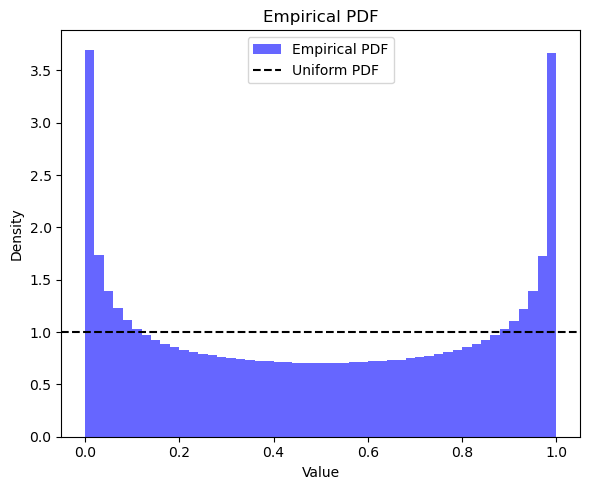

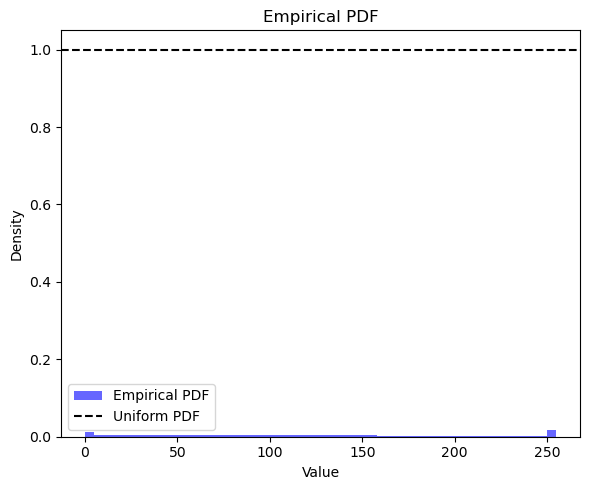

In [17]:
label_idx = 1
epsilon = 1e-4
set_name = 'cifar-gray'
pixel_size = cifar_images.shape[-1]
train_images = cifar_gray[torch.tensor(cifar_labels) == label_idx,:,:].squeeze(dim=1)

# set_name == 'fashion-mnist'
# images = fashion_mnist_images[fashion_mnist_labels == label_idx]
# pixel_size = images.shape[2]
# train_images = fashion_mnist_images[fashion_mnist_labels == label_idx]
# num_samples = 5000
# train_images = torch.randint(0,255,(num_samples, pixel_size, pixel_size), dtype=torch.uint8)




num_samples = train_images.shape[0]
num_samples = min(num_samples, train_images.shape[0])
pixel_cdf_map = compute_pixel_cdf_map(train_images.squeeze())
# transformed_images = map_images_using_cdf(train_images.squeeze().reshape(-1,pixel_size,pixel_size), pixel_cdf_map)
uniform_real_images = transform_dataset_to_uniform_distribution(train_images, pixel_cdf_map, reverse=False)
# uniform_real_images, _ = transform_dataset_to_uniform_and_gaussian_vectorized(train_images)
covariance_matrix_real_images, _ = compute_mean_and_covariance_in_data_space(train_images, epsilon=epsilon)
covariance_matrix_real_uniform, _ = compute_mean_and_covariance_in_data_space(uniform_real_images, epsilon=epsilon)
covariance_matrix_real_gaussian = compute_gaussian_covariance_from_uniform(covariance_matrix_real_uniform, epsilon = epsilon)


# uniform_fake_images = generate_random_uniform_images(covariance_matrix_real_uniform, num_samples = num_samples)
uniform_fake_images = generate_random_uniform_images(covariance_matrix_real_uniform, num_samples = num_samples)
uniform_fake_images = generate_random_uniform_images_from_gaussian(covariance_matrix_real_gaussian, num_samples= num_samples)
# uniform_fake_images = uniform_real_images
# uniform_fake_images = transform_data_to_have_the_true_covariance(uniform_fake_images, covariance_matrix_real_uniform)
# uniform_fake_images = (uniform_fake_images - uniform_fake_images.min()) / (uniform_fake_images.max() - uniform_fake_images.min())

# uniform_fake_images = generate_random_uniform_images(torch.eye(pixel_size**2), num_samples = num_samples)
# uniform_fake_images = torch.rand(num_samples,pixel_size,pixel_size)

covariance_matrix_fake_uniform, _ = compute_mean_and_covariance_in_data_space(uniform_fake_images, epsilon=epsilon)
# plot_histogram_of_data(uniform_fake_images)
# print(uniform_fake_images.min(), uniform_fake_images.max())
plot_histogram_of_data(uniform_fake_images)

synthetic_images = transform_dataset_to_uniform_distribution(uniform_fake_images, pixel_cdf_map, reverse=True)
# synthetic_images = transform_data_to_have_the_true_covariance(synthetic_images.float(), covariance_matrix_real_images.float())
# synthetic_images = 255*min_max_normalization(synthetic_images)
print(synthetic_images.min(), synthetic_images.max())
plot_histogram_of_data(synthetic_images)

plot_synthetic_images(synthetic_images.unsqueeze(0), label_idx, set_name=set_name, number_of_rows_and_columns=5)


covariance_matrix_fake_uniform, _ = compute_mean_and_covariance_in_data_space(uniform_fake_images, epsilon=epsilon)
print(torch.norm(covariance_matrix_real_uniform-covariance_matrix_fake_uniform))
# print(torch.diag(covariance_matrix_fake_uniform)*12)

covariance_matrix_fake_images, _ = compute_mean_and_covariance_in_data_space(synthetic_images, epsilon=epsilon)
print(torch.norm(covariance_matrix_real_images-covariance_matrix_fake_images))

      
      



In [15]:
def generate_random_uniform_images(covariance_matrix_real_uniform, num_samples):
    """
    Generates samples from a uniform distribution with the given covariance matrix.

    Args:
        covariance_matrix_real_uniform (torch.Tensor): Desired covariance matrix of shape (p*p, p*p).
        num_samples (int): Number of samples to generate.

    Returns:
        torch.Tensor: Uniformly distributed images with the specified covariance matrix,
                      shape (num_samples, p, p).
    """
    p2 = covariance_matrix_real_uniform.shape[0]  # Number of pixels squared (p*p)
    pixel_size = int(p2 ** 0.5)  # Extract pixel size (p)

    # Compute Cholesky decomposition (or an alternative decomposition if needed)
    L = torch.linalg.cholesky(covariance_matrix_real_uniform)

    # Generate uniform random samples in [0,1]
    uniform_samples = torch.rand(num_samples, p2)

    # Apply transformation to induce the desired covariance
    transformed_uniform_samples = torch.matmul(uniform_samples, L.T)

    # Rescale back to [0,1] (Min-Max normalization)
    min_val, max_val = transformed_uniform_samples.min(), transformed_uniform_samples.max()
    transformed_uniform_samples = (transformed_uniform_samples - min_val) / (max_val - min_val)

    # Reshape into images
    transformed_uniform_images = transformed_uniform_samples.view(num_samples, pixel_size, pixel_size)

    return transformed_uniform_images
